In [1]:
# Histograms for interphase vs. early pro-metaphase

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMitosisExt
Wed Apr 27 16:16:38 PDT 2022


In [3]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control = controller.Controller(general.load_config_file(path_config))
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape, control.get_staging())

(202847, 1290) /allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
space = shapespace.ShapeSpace(control)
space.execute(df)

In [6]:
path_cvapipe = Path(control.get_staging()).parent
dsname = "m2"
datasets = {
    dsname: {
        "perturbed": f"{path_cvapipe}/local_staging_m3"
    }}

In [7]:
smapper = shapespace.ShapeSpaceMapper(space, output_folder="./")
smapper.use_full_base_dataset()
smapper.set_make_plots_off()
smapper.set_distance_threshold(1e10)
smapper.map(datasets)

	m2 loaded. (981, 1255)


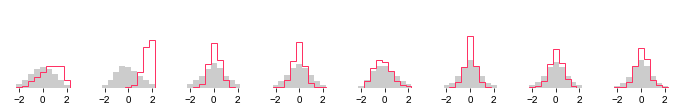

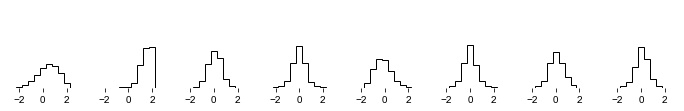

In [14]:
pmaker = plotting.ShapeSpaceMapperPlotMaker(control, "./")
pmaker.set_dataframe(smapper.result)
pmaker.plot_mapping_1d(display_both=False, ymax=1.5)

In [15]:
for (fig, _), name in zip(pmaker.figs, ["hists", "hists_matched"]):
    fig.savefig(f"{name}-{dsname}.pdf")

### Reconstruct shapes of individual and matched datasets

In [10]:
# These variables should match between control and perturbed dataset
nisos = control.get_number_of_interpolating_points()
inner_alias = control.get_inner_most_alias_to_parameterize()
outer_alias = control.get_outer_most_alias_to_parameterize()

In [11]:
path_step = Path(datasets[dsname]["perturbed"]) / "shapemode"
config_pt = general.load_config_file(path_step, fname="parameters.yaml")
control_pt = controller.Controller(config_pt)
device_pt = io.LocalStagingIO(control_pt)

In [12]:
meshes = {"ct": {}, "pt": {}, "mt": {}}
meshes["ct"]["inner"] = device.read_mean_shape_mesh(inner_alias)
meshes["ct"]["outer"] = device.read_mean_shape_mesh(outer_alias)
meshes["pt"]["inner"] = device_pt.read_mean_shape_mesh(inner_alias)
meshes["pt"]["outer"] = device_pt.read_mean_shape_mesh(outer_alias)
meshes["mt"]["inner"] = device.read_vtk_polydata(f"./avgshape/{dsname}_{inner_alias}_matched.vtk")
meshes["mt"]["outer"] = device.read_vtk_polydata(f"./avgshape/{dsname}_{outer_alias}_matched.vtk")

In [13]:
instances = []
for _, mesh in meshes.items():
    domain, _ = cytoparam.voxelize_meshes([mesh["outer"], mesh["inner"]])    
    domain = np.pad(domain, ((5,5),(5,5),(5,5)))
    domain_nuc = (255*(domain>1)).astype(np.uint8)
    domain_mem = (255*(domain>0)).astype(np.uint8)
    instances.append(np.stack([domain_nuc, domain_mem, domain_mem], axis=0))

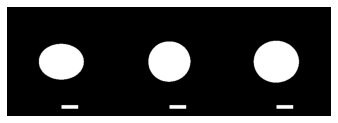

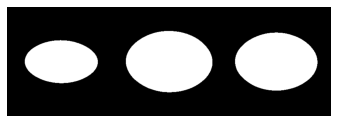

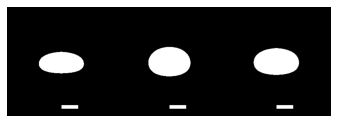

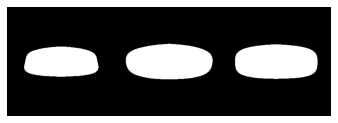

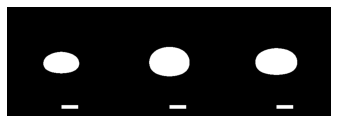

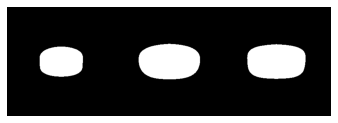

In [14]:
mode = {
    "nuc": "center_nuc",
    "mem": "center_nuc",
    "gfp": "center_nuc"
}
importlib.reload(common)
args = {"gridspec_kw": {"hspace": 0, "wspace": -0.1}, "sharex": True, "sharey": True}
for orient in ["z", "y", "x"]:
    for alias in ["nuc", "mem"]:
        fig, axs = plt.subplots(1,len(instances), figsize=(2*len(instances), 2), **args)
        for ax, instance in zip(axs, instances):
            ax.axis("off")
            proj = common.Projector(instance, box_size=300)
            proj.set_projection_mode(ax=orient, mode=mode)
            proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.108, "length":5})
        plt.savefig(f"FigureMitosis2_shapes_{dsname}_{alias}_{orient}.png", dpi=150)
        plt.show()

In [15]:
common.now("complete")

complete 2022-04-26 20:23:30
